# Problem Statement and Significance

To succeed in the highly competitive world of online shopping, understanding customer preferences and evaluating product performance is critical for sellers to thrive. The primary challenge addressed in this analysis is deciphering what customers desire and assessing how well products are faring. The exploration will specifically investigate the potential connections between product ratings and various factors such as pricing, discounts, and customer reviews. The primary goal is to provide sellers with concrete recommendations, allowing them to improve their product listings, pricing tactics, and marketing efforts on Amazon. The end goal is to elevate customer satisfaction and drive increased sales in this dynamic digital marketplace.

## Dataset and Its Relevance

The dataset chosen for analysis is a dataset of over 1,000 products listed on Amazon encompassing details such as product names, categories, prices, ratings, and user reviews. This dataset is immensely relevant to the identified problem because it serves as a rich source of real-world data reflecting customer behavior and product dynamics on the Amazon platform.

The dataset from Amazon appears to include the following columns:

1. **Product ID:** Unique identifier for each product.
2. **Product Name:** Name of the product.
3. **Category:** Product category.
4. **Discounted Price:** Price of the product after discount.
5. **Actual Price:** Original price of the product.
6. **Discount Percentage:** Percentage of discount on the product.
7. **Rating:** Average rating of the product.
8. **Rating Count:** Number of ratings the product has received.
9. **About Product:** Description of the product.
10. **User ID:** IDs of users who reviewed the product.
11. **User Name:** Names of users who reviewed the product.
12. **Review ID:** IDs of the reviews.
13. **Review Title:** Titles of the reviews.
14. **Review Content:** Content of the reviews.
15. **Image Link:** Link to the product image.
16. **Product Link:** Link to the product on Amazon.

By leveraging this dataset, the analysis aims to uncover patterns, correlations, and trends that can offer valuable insights into customer preferences and purchasing behaviors. The relevance of this dataset lies in its ability to provide a real-world foundation for deriving practical recommendations that can benefit sellers in the competitive e-commerce environment.

## Our approach to solving or analyzing the problem and gaining valuable insights.

In order to analyze data from a raw CSV file, the process involves a multi-step approach. Firstly, the raw data is parsed and cleaned and is stored in a new CSV File. Subsequently, a normalized database table is created using a relational database like SQLite, with the table structure defined based on the parsed data. SQL commands are employed to both create the table and insert the parsed data into it from new CSV file that we created earlier. Finally, for data analysis, SQL join statements are utilized to retrieve relevant data from the database, and the result is brought into Pandas for further analysis and visualization. This hybrid approach leverages the strengths of both Python's native capabilities and Pandas, ensuring effective data parsing, storage, and analysis.


### The provided code parses data from a dataset CSV file, performs data cleaning operations, and stores the cleaned data in a new location.

In [6]:
import csv
import pandas as pd
import sqlite3

file_path = 'amazon.csv'
cleaned_file_path = 'cleaned_amazon_data.csv'

def clean_data(value, data_type):
    if data_type == 'price':
        try:
            return float(value.replace('â‚¹', '').replace('₹', '').replace(',', ''))
        except ValueError:
            return None
    elif data_type == 'int':
        try:
            return int(value.replace(',', ''))
        except ValueError:
            return 0  # Return 0 or None if the conversion fails
    elif data_type == 'float':
        try:
            return float(value)
        except ValueError:
            return None
    return value


with open(file_path, 'r', encoding='utf-8') as file, open(cleaned_file_path, 'w', newline='', encoding='utf-8') as cleaned_file:
    reader = csv.DictReader(file)
    writer = csv.DictWriter(cleaned_file, fieldnames=reader.fieldnames)
    
    writer.writeheader()
    for row in reader:
        row['discounted_price'] = clean_data(row['discounted_price'], 'price')
        row['actual_price'] = clean_data(row['actual_price'], 'price')
        row['rating_count'] = clean_data(row['rating_count'], 'int')
        row['rating'] = clean_data(row['rating'], 'float')
        
        writer.writerow(row)

print(f"Cleaned data written to {cleaned_file_path}")

Cleaned data written to cleaned_amazon_data.csv


The provided code snippet establishes an SQLite database named 'amazon_products.db' and creates four interrelated tables to organize data from the Amazon Products dataset. The primary table, `Products`, encompasses product details with a composite primary key. Three additional tables—`Prices`, `Ratings`, and `Reviews`—are created with foreign key references to the `Products` table, establishing a structured and interconnected database schema. The `Prices` table stores pricing information, `Ratings` captures product ratings and counts, and `Reviews` stores review details. The code executes SQL commands to create these tables, commits the changes, and closes the database connection, signaling the successful creation of a well-organized SQLite database primed for subsequent data manipulation and analysis.

In [7]:
# Establishing a connection to a new SQLite database
conn = sqlite3.connect('amazon_products.db')
cursor = conn.cursor()

# SQL commands to create the required tables without the Users table
create_products_table = """
CREATE TABLE IF NOT EXISTS Products (
    product_id TEXT,
    product_name TEXT,
    category TEXT,
    img_link TEXT,
    product_description TEXT,
    product_link TEXT,
    PRIMARY KEY (product_id, product_name)
);
"""

create_prices_table = """
CREATE TABLE IF NOT EXISTS Prices (
    price_id INTEGER PRIMARY KEY AUTOINCREMENT,
    product_id TEXT,
    actual_price REAL,
    discounted_price REAL,
    discounted_percentage TEXT,
    FOREIGN KEY (product_id) REFERENCES Products (product_id)
);
"""

create_ratings_table = """
CREATE TABLE IF NOT EXISTS Ratings (
    rating_id INTEGER PRIMARY KEY AUTOINCREMENT,
    product_id TEXT,
    rating REAL,
    rating_count INTEGER,
    FOREIGN KEY (product_id) REFERENCES Products (product_id)
);
"""

create_reviews_table = """
CREATE TABLE IF NOT EXISTS Reviews (
    product_id TEXT PRIMARY KEY,
    review_title TEXT,
    review_content TEXT,
    FOREIGN KEY (product_id) REFERENCES Products (product_id)
);
"""

# Executing the SQL commands to create the tables
cursor.execute(create_products_table)
cursor.execute(create_prices_table)
cursor.execute(create_ratings_table)
cursor.execute(create_reviews_table)

# Committing the changes and closing the connection to the database
conn.commit()
conn.close()

print("Tables created successfully in the SQLite database 'amazon_products.db'.")


Tables created successfully in the SQLite database 'amazon_products.db'.


### Loading Parsed Data into a Normalized Database Table 

In [8]:
# Connect to the SQLite database
conn = sqlite3.connect('amazon_products.db')
cursor = conn.cursor()

# Function to execute an insert statement
def execute_insert(statement, data):
    try:
        cursor.execute(statement, data)
    except sqlite3.IntegrityError as e:
        print(f"Insert error: {e}, Data: {data}")

# Read the cleaned data and insert into the database
with open(cleaned_file_path, 'r', encoding='utf-8') as file:
    reader = csv.DictReader(file)
    
    for row in reader:
        # Prepare data for each table and execute insert
        product_data = (row['product_id'], row['product_name'], row['category'], 
                        row['img_link'], row['about_product'], row['product_link'])
        execute_insert('INSERT OR IGNORE INTO Products VALUES (?, ?, ?, ?, ?, ?)', product_data)

        price_data = (row['product_id'], row['actual_price'], row['discounted_price'], 
                      row['discount_percentage'])
        execute_insert('INSERT INTO Prices (product_id, actual_price, discounted_price, discounted_percentage) VALUES (?, ?, ?, ?)', price_data)

        rating_data = (row['product_id'], row['rating'], row['rating_count'])
        execute_insert('INSERT INTO Ratings (product_id, rating, rating_count) VALUES (?, ?, ?)', rating_data)

        review_data = (row['product_id'], row['review_title'], row['review_content'])
        execute_insert('INSERT OR REPLACE INTO Reviews (product_id, review_title, review_content) VALUES (?, ?, ?)', review_data)
        
        


# Committing the changes and closing the connection to the database
conn.commit()
conn.close()

### The below SQL statement uses joins to reconstruct the original data and load it into a Pandas DataFrame.

In [9]:
import sqlite3
import csv

# Path to the SQLite database
db_path = 'amazon_products.db'

# Establishing a connection to the SQLite database
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# SQL query to join the tables
join_query = """
SELECT p.product_id, p.product_name, p.category, p.img_link, p.product_description, p.product_link, 
       AVG(pr.actual_price) AS average_actual_price, 
       AVG(pr.discounted_price) AS average_discounted_price,
       GROUP_CONCAT(DISTINCT pr.discounted_percentage) AS distinct_discounted_percentage,
       AVG(r.rating) AS average_rating, 
       COUNT(DISTINCT r.rating_id) AS rating_count,  -- Assuming rating_id is a unique identifier for each rating
       GROUP_CONCAT(re.review_title, '; ') AS combined_review_titles, 
       GROUP_CONCAT(re.review_content, '; ') AS combined_review_contents
FROM Products p
LEFT JOIN Prices pr ON p.product_id = pr.product_id
LEFT JOIN Ratings r ON p.product_id = r.product_id
LEFT JOIN Reviews re ON p.product_id = re.product_id
GROUP BY p.product_id;
"""

cursor.execute(join_query)
rows = cursor.fetchall()

# Column headers for the combined data
headers = ['product_id', 'product_name', 'category', 'img_link', 'product_description', 'product_link',
           'actual_price', 'discounted_price', 'discounted_percentage',
           'rating', 'rating_count',
           'review_title', 'review_content']

# Close the database connection
conn.close()
# Path for the combined CSV file
combined_csv_path = 'combined_data.csv'

# Write the combined data to the CSV file
with open(combined_csv_path, 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(headers)
    writer.writerows(rows)

print(f"Combined data written to {combined_csv_path}")


Combined data written to combined_amazon_data.csv


### Based on this dataset and the problem statement, the analysis will focus on:

1. **Sentiment Analysis of Reviews**: Analyzing the content of customer reviews to gauge sentiments towards products.

2. **Correlation Analysis**: Investigating the relationships between product ratings, pricing (actual and discounted), and discount percentages.

3. **Category-wise Analysis**: Examining how different product categories perform in terms of ratings and sales.

4. **Visualization**: Creating visual representations of the key findings, such as correlation plots, sentiment distributions, and category-wise performance charts.

5. **Strategic Recommendations**: Based on the findings, recommendations will be made to optimize product listings, pricing strategies, and marketing efforts.

Let's start with a sentiment analysis of the review content, followed by a correlation analysis between product ratings and pricing. Then, we'll look into category-wise performance and conclude with actionable insights.


In [12]:
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns

# Load the combined dataset
file_path = 'combined__data.csv'
amazon_data = pd.read_csv(file_path)

# Sentiment Analysis
# Calculating sentiment polarity
amazon_data['sentiment_polarity'] = amazon_data['review_content'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# Categorizing sentiment based on polarity
amazon_data['sentiment_category'] = amazon_data['sentiment_polarity'].apply(
    lambda x: 'positive' if x > 0.1 else ('negative' if x < -0.1 else 'neutral')
)

In [13]:
amazon_data.head()

,Unnamed: 0,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,review_id,review_title,review_content,sentiment_polarity,sentiment_category
0,0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories|Accessories&Peripherals|...,399.0,1099.0,64%,4.2,24269,High Compatibility : Compatible With iPhone 12...,"R3HXWT0LRP0NMF,R2AJM3LFTLZHFO,R6AQJGUP6P86,R1K...","Satisfied,Charging is really fast,Value for mo...",Looks durable Charging is fine tooNo complains...,0.481944,positive
1,1,B098NS6PVG,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Computers&Accessories|Accessories&Peripherals|...,199.0,349.0,43%,4.0,43994,"Compatible with all Type C enabled devices, be...","RGIQEG07R9HS2,R1SMWZQ86XIN8U,R2J3Y1WL29GWDE,RY...","A Good Braided Cable for Your Type C Device,Go...",I ordered this cable to connect my phone to An...,0.274318,positive
2,2,B096MSW6CT,Sounce Fast Phone Charging Cable & Data Sync U...,Computers&Accessories|Accessories&Peripherals|...,199.0,1899.0,90%,3.9,7928,【 Fast Charger& Data Sync】-With built-in safet...,"R3J3EQQ9TZI5ZJ,R3E7WBGK7ID0KV,RWU79XKQ6I1QF,R2...","Good speed for earlier versions,Good Product,W...","Not quite durable and sturdy,https://m.media-a...",0.600000,positive
3,3,B08HDJ86NZ,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,Computers&Accessories|Accessories&Peripherals|...,329.0,699.0,53%,4.2,94363,The boAt Deuce USB 300 2 in 1 cable is compati...,"R3EEUZKKK9J36I,R3HJVYCLYOY554,REDECAZ7AMPQC,R1...","Good product,Good one,Nice,Really nice product...","Good product,long wire,Charges good,Nice,I bou...",0.240370,positive
4,4,B08CF3B7N1,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,Computers&Accessories|Accessories&Peripherals|...,154.0,399.0,61%,4.2,16905,[CHARGE & SYNC FUNCTION]- This cable comes wit...,"R1BP4L2HH9TFUP,R16PVJEXKV6QZS,R2UPDB81N66T4P,R...","As good as original,Decent,Good one for second...","Bought this instead of original apple, does th...",0.262740,positive


In [17]:
sentiment_counts = amazon_data['sentiment_category'].value_counts()

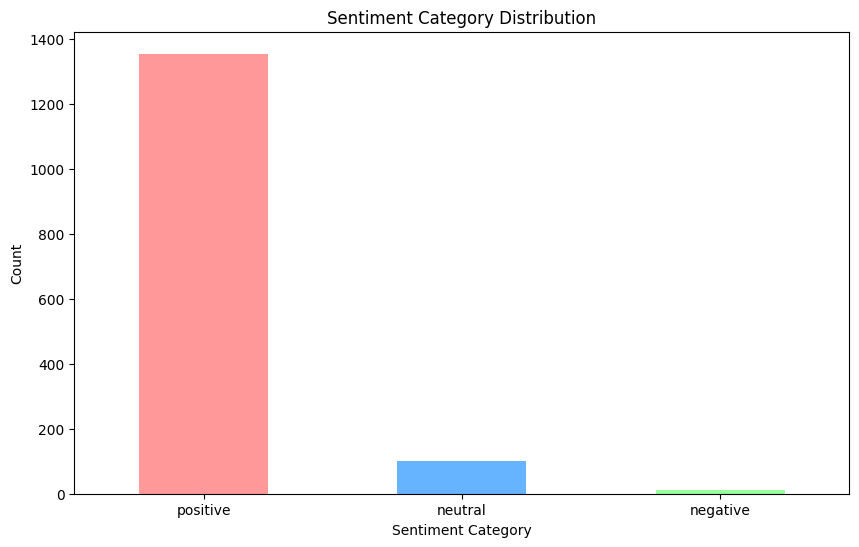

In [19]:
plt.figure(figsize=(10, 6))
sentiment_counts.plot(kind='bar', color=['#ff9999', '#66b3ff', '#99ff99'])
plt.title('Sentiment Category Distribution')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.show()

In order to understand and analyze how much the dataset is correlated we are doing a correlation plot to interpret the relations between them.

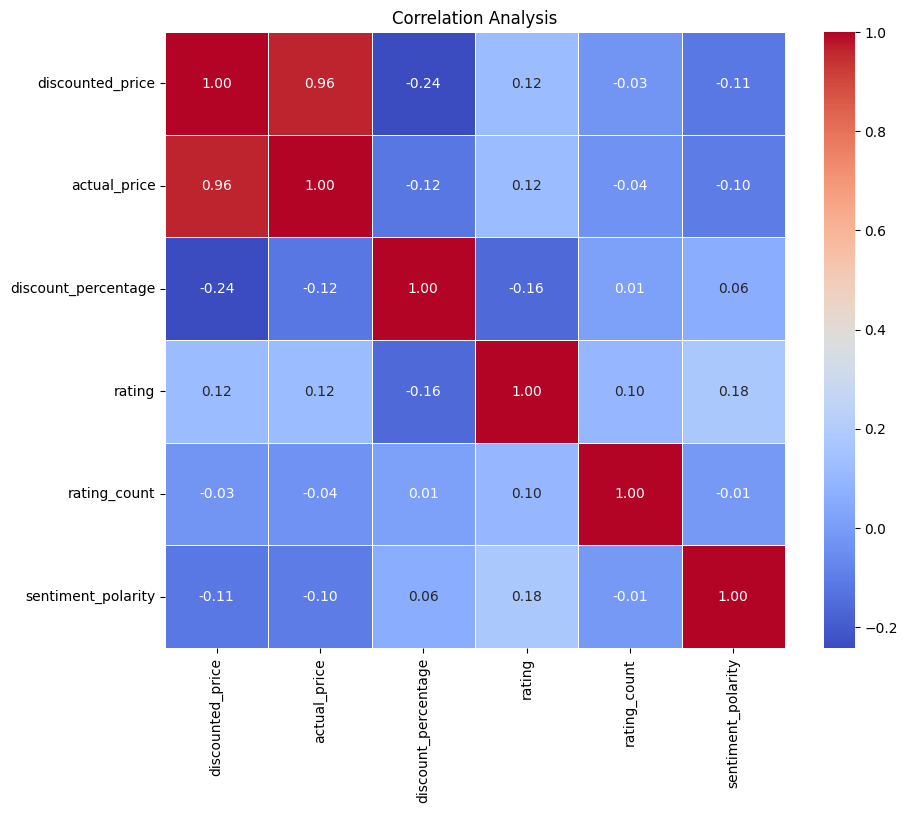

In [15]:

# Correlation Analysis
amazon_data['discount_percentage'] = amazon_data['discount_percentage'].str.rstrip('%').astype('float')
correlation_matrix = amazon_data[['discounted_price', 'actual_price', 'discount_percentage', 'rating', 'rating_count', 'sentiment_polarity']].corr()

# Plotting the Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Analysis')
plt.show()



### Correlation Analysis Summary


1. **Discounted Price and Actual Price**: 
   - Correlation Coefficient: 0.96
   - Interpretation: Strong positive correlation, indicating higher-priced products have higher discounted prices.

2. **Discounted Price and Rating**: 
   - Correlation Coefficient: 0.12
   - Interpretation: Weak correlation, suggesting that product pricing does not significantly influence its rating.

3. **Actual Price and Rating**: 
   - Correlation Coefficient: 0.12
   - Interpretation: Weak correlation, indicating price is not a primary determinant of product rating.

4. **Rating and Rating Count**: 
   - Correlation Coefficient: 0.10
   - Interpretation: Moderate positive correlation, suggesting products with higher ratings attract more reviews.

5. **Sentiment Polarity and Rating**: 
   - Correlation Coefficient: 0.18
   - Interpretation: Moderate to strong correlation, reflecting the alignment of sentiment in reviews with overall product rating.

6. **Sentiment Polarity and Rating Count**: 
   - Correlation Coefficient: -0.01
   - Interpretation: Weak correlation, indicating the quantity of reviews is not strongly influenced by the sentiment in existing reviews.

7. **Price (Discounted/Actual) and Sentiment Polarity**: 
   - Correlation Coefficients: -0.11 (Discounted Price), -0.10 (Actual Price)
   - Interpretation: Weak correlations, suggesting that the sentiment expressed in reviews is not strongly influenced by product price.
   
Overall, these insights reveal that while there are some expected relationships, like between price and discounted price, and sentiment polarity and rating, other factors such as the influence of price on ratings and sentiment are less pronounced. This suggests that customer ratings and sentiments are driven more by their experiences and satisfaction with the product than its price.


Next, category-wise analysis is done to understand how different product categories perform in terms of ratings and sales. This analysis will help in identifying which categories are more favored by customers and how they correlate with ratings and sentiments. We'll visualize the results for a clearer understanding.

/var/folders/8k/lszr__h12tj1jh1v7cp2v1xr0000gn/T/ipykernel_93615/1988373137.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='rating', y='primary_category', data=category_analysis, palette='viridis')
/var/folders/8k/lszr__h12tj1jh1v7cp2v1xr0000gn/T/ipykernel_93615/1988373137.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='sentiment_polarity', y='primary_category', data=category_analysis, palette='magma')


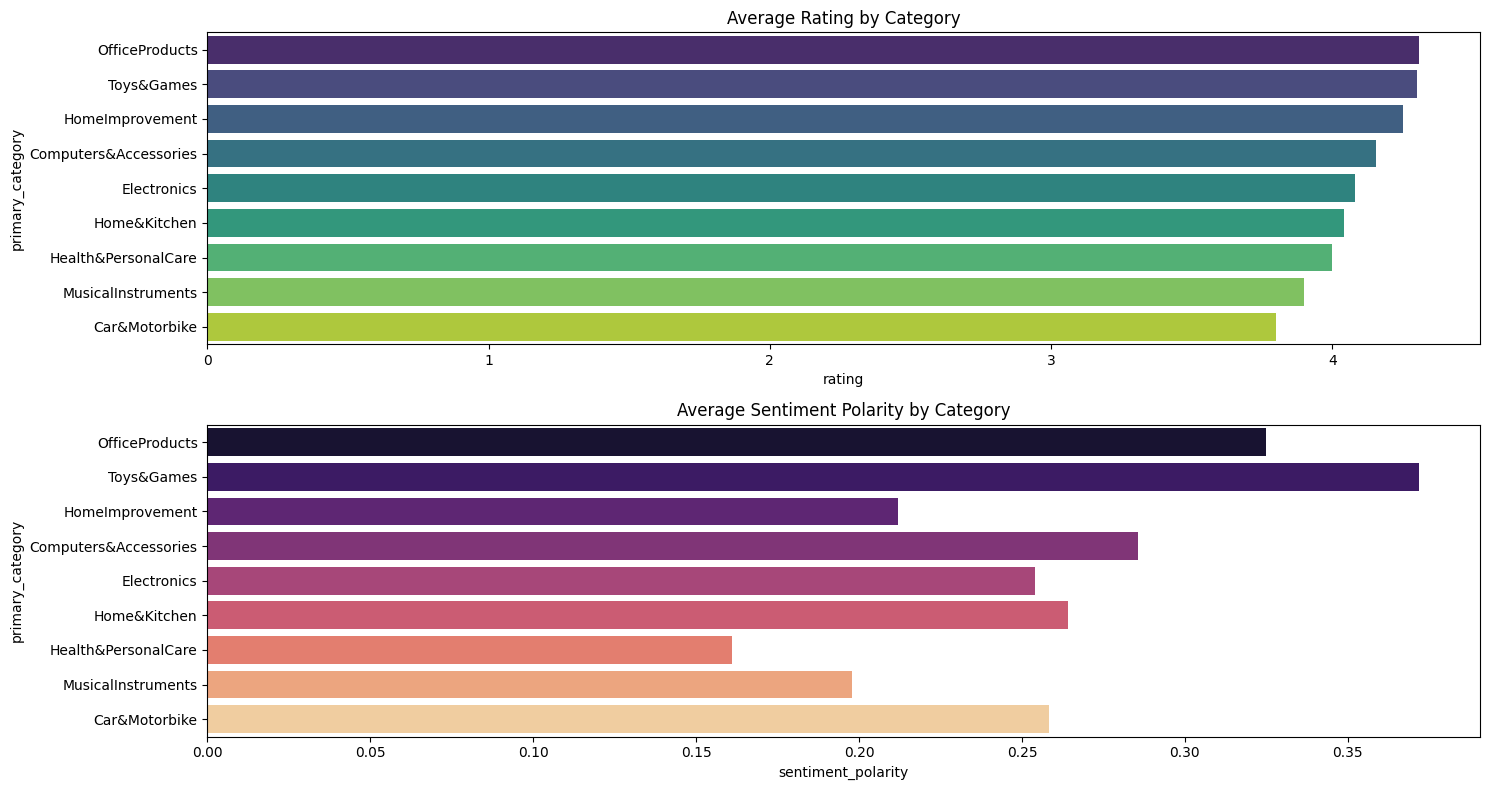

In [21]:

# Category-wise Analysis
amazon_data['primary_category'] = amazon_data['category'].apply(lambda x: x.split('|')[0])
category_analysis = amazon_data.groupby('primary_category').agg({
    'rating': 'mean',
    'sentiment_polarity': 'mean',
    'rating_count': 'sum'
}).reset_index()
category_analysis = category_analysis.sort_values(by='rating', ascending=False)

# Visualizing Category-wise Performance
plt.figure(figsize=(15, 8))

# Average Rating by Category
plt.subplot(2, 1, 1)
sns.barplot(x='rating', y='primary_category', data=category_analysis, palette='viridis')
plt.title('Average Rating by Category')

# Average Sentiment Polarity by Category
plt.subplot(2, 1, 2)
sns.barplot(x='sentiment_polarity', y='primary_category', data=category_analysis, palette='magma')
plt.title('Average Sentiment Polarity by Category')

plt.tight_layout()
plt.show()


The category-wise analysis provides valuable insights into customer preferences and product performance on Amazon:

1. **Average Rating by Category**: Certain categories show higher average ratings, indicating greater customer satisfaction in these areas. Categories with higher ratings are likely to be more popular and well-received by customers.

2. **Average Sentiment Polarity by Category**: Similar to the ratings, the sentiment polarity of reviews also varies by category. Categories with higher sentiment polarity are indicative of more positive customer feedback and experiences.

3. **Popularity/Sales Performance**: The analysis also considered the sum of rating counts per category, which serves as a proxy for popularity or sales performance. Categories with higher rating counts suggest greater customer engagement and potentially higher sales volumes.


### Strategic Recommendations:
Based on the findings from the analysis, here are some actionable insights:

- **Focus on High-Performing Categories**: Vendors should consider concentrating their efforts on categories with higher ratings and positive sentiments, as these are likely to be more successful and well-received by customers.

- **Optimize Listings in Lower-Performing Categories**: For categories with lower ratings or sentiment polarity, vendors should review their product listings and customer feedback to identify areas for improvement.

- **Pricing Strategy**: Since the correlation between price and ratings is not strong, vendors should focus on competitive pricing strategies that do not compromise product quality or customer satisfaction.

- **Leverage Customer Feedback**: Regularly analyzing customer reviews and sentiments can provide valuable insights for product improvement and customer experience enhancement.

- **Marketing Focus**: Tailoring marketing efforts to highlight the strengths of products in high-rated categories can attract more customers and increase sales.

This analysis demonstrates the power of data in understanding consumer behavior and market trends, enabling vendors to make informed decisions to optimize their presence and performance on the Amazon platform.
